<a href="https://colab.research.google.com/github/AlexandreLarget/tensorflow_certification_training/blob/main/05_transfer_learning_with_TF_part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TF Part2: Fine Tuning

In [ ]:
!nvidia-smi

Wed Jul 13 21:39:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

First, we will reimport functions from previous video from GITHUB

In [ ]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-13 21:39:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-13 21:39:32 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper function just downloaded
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem.

Link : https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-13 21:39:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   101MB/s    in 1.6s    

2022-07-13 21:39:36 (101 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
# Check out image number and stuff
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
 # Check out class manes
 train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[5.88265305e+01 3.65714302e+01 2.04081631e+00]
   [5.46683655e+01 3.16428566e+01 2.11734700e+00]
   [5.10051003e+01 3.00663261e+01 3.57142878e+00]
   ...
   [4.57140684e+00 2.57140684e+00 5.99993467e+00]
   [3.78572750e+00 1.81124222e+00 2.73469758e+00]
   [6.19899225e+00 5.19899225e+00 3.19899201e+00]]

  [[7.34540787e+01 4.85714302e+01 1.50000000e+01]
   [7.05714264e+01 4.52857132e+01 1.44897957e+01]
   [6.80153046e+01 4.38724480e+01 1.82602043e+01]
   ...
   [2.19895935e+00 1.98959351e-01 3.59687805e+00]
   [4.22451782e+00 2.36228490e+00 2.93877745e+00]
   [1.09286413e+01 9.92864132e+00 7.12245369e+00]]

  [[8.49387741e+01 5.57908173e+01 2.55051041e+01]
   [8.39438782e+01 5.45000000e+01 2.62704086e+01]
   [8.30459213e+01 5.37346954e+01 2.85459194e+01]
   ...
   [4.35714340e+00 2.35714316e+00 5.35714340e+00]
   [9.21433830e+00 8.21433830e+00 6.07145500e+00]
   [1.79235668e+01 1.69235668e+01 1.26429272e+01]]

  ...

  [[9.21935558e+00 9.21935558e+00 1.12193556e+01]
   [8

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model 
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNEt50V2, nned to normalize input
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after pasing through the base model: {x.shape}")

# 6. Average pool th eoutputs of the bse model
x = tf.keras.layers.GlobalAveragePooling2D(name="flobal_average_pooling_layer")(x)
print(f"Shape after GlobalAvragePooling2D: {x.shape}")

# 7. Create the output layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

Shape after pasing through the base model: (None, 7, 7, 1280)
Shape after GlobalAvragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220713-222532
Epoch 1/5
24/24 [==============================] - 15s 397ms/step - loss: 1.9027 - accuracy: 0.4107 - val_loss: 1.3502 - val_accuracy: 0.6908
Epoch 2/5
24/24 [==============================] - 8s 334ms/step - loss: 1.1465 - accuracy: 0.7320 - val_loss: 0.9268 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - 8s 335ms/step - loss: 0.8537 - accuracy: 0.7960 - val_loss: 0.7575 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 8s 333ms/step - loss: 0.6849 - accuracy: 0.8400 - val_loss: 0.6693 - val_accuracy: 0.8332
Epoch 5/5
24/24 [==============================] - 8s 333ms/step - loss: 0.5989 - accuracy: 0.8507 - val_loss: 0.6144 - val_accuracy: 0.8384


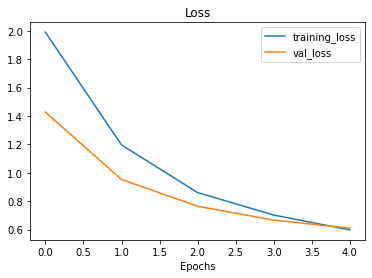

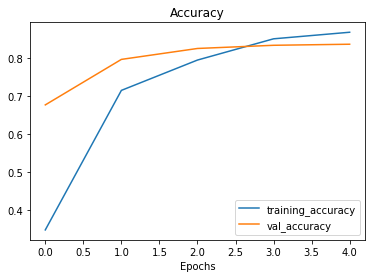

In [ ]:
# Get the loss curves
plot_loss_curves(history_0)

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 flobal_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer.

Wea have a tensor sfter our model goes through `base_model` of shape (None, 7, 7,, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape= (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor} \n")

# Pass the random tensor through a global average pooling 2D layer
global_av_pooled = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_av_pooled}\n")

# Check the shape of both
print(f"Shape of the input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_av_pooled.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of the input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
 # Let's replicate the GlobalAveragePool2D layer
 tf.reduce_mean(input_tensor, axis=[1, 2]) # Fait la moyenne des dimesnions 1 et 2

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Runing a series of transfer learning experiments

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the trainig data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

### Getting and preprocessing data for our model_1

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip") 

--2022-07-13 21:41:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 108.177.11.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   102MB/s    in 1.3s    

2022-07-13 21:41:13 (102 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with ?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [ ]:
 # Setup data loaders
 IMG_SIZE = (224, 224)
 train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)
 
 test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

The benefits of using data augmentation in a layer is that it uses the GPU.
Therefor, because it is run with the model, you can export the data augmentation within the model.

In [ ]:
# Create a data augmentation stage
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  # tf.keras.layers.experimental.preprocessing.Rescale(1./255) # Neede for ResNet50V2, not for EfficientNet
], name="data_augmentation")

In [ ]:
print(tf.__version__)

2.8.2


### Visualize our data augmentation layer

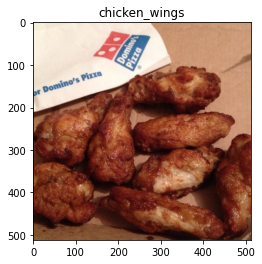

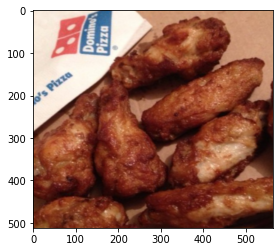

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(target_class);

# Read the augmented data
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)

In [ ]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model_1: feature extraction transfer learnng on 1%

In [ ]:
# Setup input shape and bsae model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in dat augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs after data augmentation
x = base_model(x, training=False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1%_data_aug")])

Saving TensorBoard log files to: transfer_learning/1%_data_aug/20220713-214118
Epoch 1/5
3/3 [==============================] - 16s 4s/step - loss: 2.3942 - accuracy: 0.0714 - val_loss: 2.2282 - val_accuracy: 0.1832
Epoch 2/5
3/3 [==============================] - 8s 4s/step - loss: 2.1440 - accuracy: 0.3143 - val_loss: 2.1109 - val_accuracy: 0.2604
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9244 - accuracy: 0.4714 - val_loss: 2.0079 - val_accuracy: 0.3364
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.8122 - accuracy: 0.4429 - val_loss: 1.9070 - val_accuracy: 0.4036
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6330 - accuracy: 0.6429 - val_loss: 1.8120 - val_accuracy: 0.4684


In [ ]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

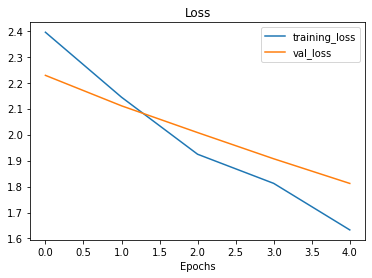

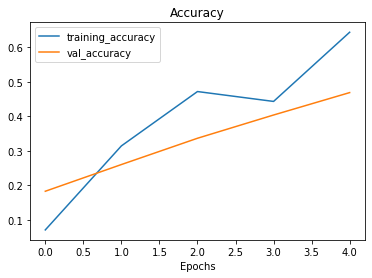

In [ ]:
# Pplot the loss curves
plot_loss_curves(history_1_percent)

## Model 2 : feature extraction transfer learning with 10% of the data

In [ ]:
# Practise recoding data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
], name="data_augmentation")

In [ ]:
# Setup inuput and shape for bae model
inputs_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation layer
x = data_augmentation(inputs)

# Bring the model after data augmentation
x = base_model(x, training=False)

# Add pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)

# Add output dense layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Build the model
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Creating a model checkup callback

It intermediately save the model during training.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoints.ckpt"

# Create a MOdelcheckpoint callback that saves the model's weight
checkpoint_callbacks =  tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                           save_weights_only=True,
                                                           save_best_only=True,
                                                           save_freq="epoch",
                                                           verbose=1)

In [ ]:
# Fit the model 2 with checkpoint callbacks
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_data_aug"),
                                   checkpoint_callbacks])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220713-214218
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0027 - accuracy: 0.3427
Epoch 1: val_loss improved from inf to 1.51773, saving model to ten_percent_model_checkpoint_weights/checkpoints.ckpt
24/24 [==============================] - 21s 628ms/step - loss: 2.0027 - accuracy: 0.3427 - val_loss: 1.5177 - val_accuracy: 0.6432
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3561 - accuracy: 0.6667
Epoch 2: val_loss improved from 1.51773 to 1.06246, saving model to ten_percent_model_checkpoint_weights/checkpoints.ckpt
24/24 [==============================] - 13s 547ms/step - loss: 1.3561 - accuracy: 0.6667 - val_loss: 1.0625 - val_accuracy: 0.7600
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0560 - accuracy: 0.7453
Epoch 3: val_loss improved from 1.06246 to 0.86905, saving model to ten_percent_model_checkpoint_weights/checkpoints.ckpt
24/24 [=

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6907 - accuracy: 0.8096


[0.690682590007782, 0.8095999956130981]

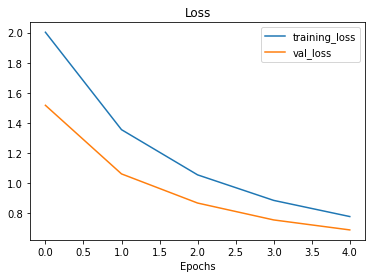

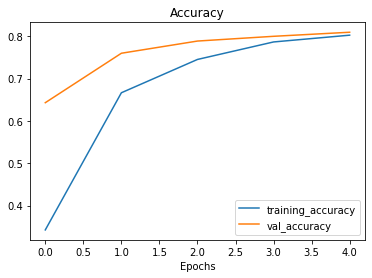

In [ ]:
plot_loss_curves(history_2)

#### Loading in checkpointed weights


In [ ]:
# Load in saved model weight and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate the model
model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6907 - accuracy: 0.8096


[0.6906825304031372, 0.8095999956130981]

In [ ]:
# It matchs the loaded weights

## Model 3: Fine-tuning an existing model on 10% of the data

🔑 **Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in our loaded model
model_2.layers

In [ ]:
# Are these layers trainable ?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f3d9ef5f6d0> True
<keras.engine.sequential.Sequential object at 0x7f3da3518410> True
<keras.engine.functional.Functional object at 0x7f3d9ea37a50> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f3d9ed26210> True
<keras.layers.core.dense.Dense object at 0x7f3d9ebf9110> True


In [ ]:
# What layers are in our base model (EfficientNetB0) and are they trainable ?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine tuning, you want to lower the learning rate by 10x to keep the weights close to their initial position
                metrics=["accuracy"])

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = 5 + 5

# Refit the model 
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                              epochs=fine_tune_epochs,
                                              validation_data=test_data,
                                               validation_steps=len(test_data),
                                               initial_epoch=history_2.epoch[-1],
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220713-214410
Epoch 5/10
24/24 [==============================] - 23s 646ms/step - loss: 0.6996 - accuracy: 0.8027 - val_loss: 0.5673 - val_accuracy: 0.8164
Epoch 6/10
24/24 [==============================] - 17s 719ms/step - loss: 0.5661 - accuracy: 0.8320 - val_loss: 0.5138 - val_accuracy: 0.8320
Epoch 7/10
24/24 [==============================] - 12s 504ms/step - loss: 0.4985 - accuracy: 0.8267 - val_loss: 0.5009 - val_accuracy: 0.8292
Epoch 8/10
24/24 [==============================] - 13s 522ms/step - loss: 0.4657 - accuracy: 0.8560 - val_loss: 0.5010 - val_accuracy: 0.8344
Epoch 9/10
24/24 [==============================] - 11s 470ms/step - loss: 0.4159 - accuracy: 0.8707 - val_loss: 0.4990 - val_accuracy: 0.8292
Epoch 10/10
24/24 [==============================] - 12s 473ms/step - loss: 0.3762 - accuracy: 0.8747 - val_loss: 0.4883 - val_accuracy: 0.8372


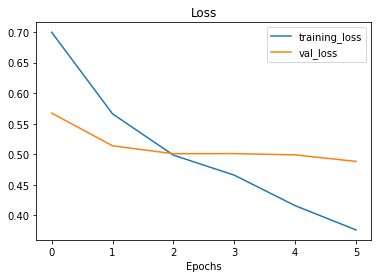

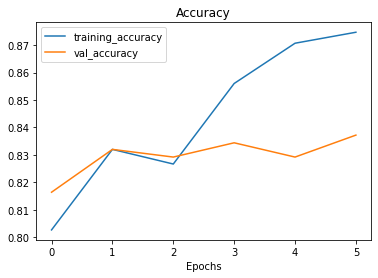

In [ ]:
# Check out the loss curves
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two Tensorflow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original and new
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val_accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend()
  plt.title("Training and Validation accuracy")

  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Val_loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend()
  plt.title("Training and Validation loss")


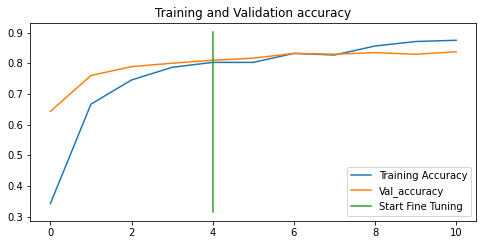

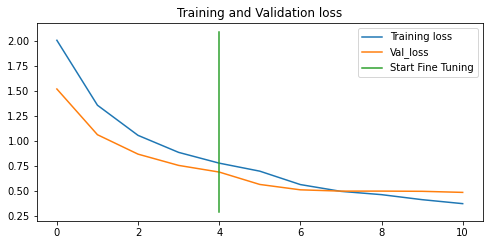

In [ ]:
compare_histories(history_2, history_fine_10_percent_data_aug)

## Model 4: Fine-tuning an existing model on all of the data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-07-13 21:46:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   294MB/s    in 1.7s    

2022-07-13 21:46:08 (294 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 

In [ ]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                  label_mode="categorical",
                                                                                  image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 120ms/step - loss: 0.4883 - accuracy: 0.8372


[0.48826864361763, 0.8371999859809875]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

Loads weights from checkpoint, that way we can fine-tune from the same sateg the 10 percent data model was fine-tuned from.

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 8s 91ms/step - loss: 0.6907 - accuracy: 0.8096


[0.6906825304031372, 0.8095999956130981]

What have we done so far :

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reload the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).


In [ ]:
# Check which layers are tunable in our model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 pooling_layer True
4 output_layer True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
fine_tune_epochs = 5 + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_2.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tuning")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tuning/20220713-221619
Epoch 5/10
235/235 [==============================] - 56s 234ms/step - loss: 0.6774 - accuracy: 0.7880 - val_loss: 0.4517 - val_accuracy: 0.8487
Epoch 6/10
235/235 [==============================] - 47s 200ms/step - loss: 0.5791 - accuracy: 0.8161 - val_loss: 0.4216 - val_accuracy: 0.8586
Epoch 7/10
235/235 [==============================] - 46s 193ms/step - loss: 0.5267 - accuracy: 0.8312 - val_loss: 0.3882 - val_accuracy: 0.8668
Epoch 8/10
235/235 [==============================] - 40s 169ms/step - loss: 0.4729 - accuracy: 0.8504 - val_loss: 0.4025 - val_accuracy: 0.8536
Epoch 9/10
235/235 [==============================] - 39s 162ms/step - loss: 0.4528 - accuracy: 0.8503 - val_loss: 0.3633 - val_accuracy: 0.8865
Epoch 10/10
235/235 [==============================] - 35s 148ms/step - loss: 0.4079 - accuracy: 0.8680 - val_loss: 0.3569 - val_accuracy: 0.8898


In [ ]:
results_fine_tune_full = model_2.evaluate(test_data)
results_fine_tune_full

79/79 [==============================] - 8s 89ms/step - loss: 0.3368 - accuracy: 0.8896


[0.3368470072746277, 0.8895999789237976]

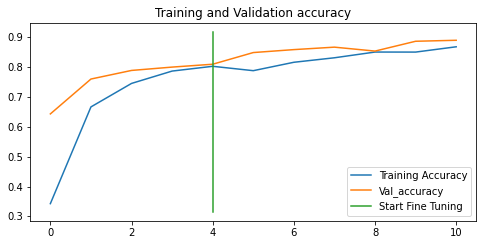

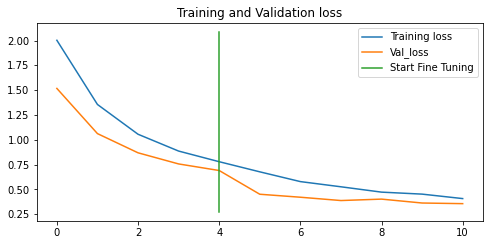

In [ ]:
compare_histories(original_history=history_2, new_history=history_fine_10_classes_full)

## Viewing our experiment data on TensorBoard

In [1]:
#!tensorboard dev upload --logdir ./transfer_learning \
#  --name "Transfer Learning Eperiments with 10 Food101 Classes" \
#  --description "A series of different transfer learning experiments with varying amount of data" \
#  --one_shot